In [19]:
import os
import shutil
import subprocess
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image

import torch
from torch.utils.data import Dataset, DataLoader, random_split
import torchvision.transforms as T

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, classification_report

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)
torch.manual_seed(RANDOM_STATE)


In [20]:
ROOT_DIR = "dataset/fruit360"
TRAIN_DIR = os.path.join(ROOT_DIR, "Training")
TEST_DIR = os.path.join(ROOT_DIR, "Test")

GITHUB_REPO = "https://github.com/fruits-360/fruits-360-100x100"
CLONE_DIR = "dataset/fruits-360-100x100"

def download_dataset():
    os.makedirs("dataset", exist_ok=True)
    subprocess.run(["git", "clone", GITHUB_REPO, CLONE_DIR], check=True)
    
    os.makedirs(ROOT_DIR, exist_ok=True)
    shutil.move(os.path.join(CLONE_DIR, "Training"), TRAIN_DIR)
    shutil.move(os.path.join(CLONE_DIR, "Test"), TEST_DIR)
    shutil.rmtree(CLONE_DIR, ignore_errors=True)

if not os.path.exists(ROOT_DIR):
    download_dataset()

assert os.path.exists(TRAIN_DIR), f"{TRAIN_DIR} not found"
assert os.path.exists(TEST_DIR), f"{TEST_DIR} not found"
print(f"Dataset ready: {ROOT_DIR}")


Dataset ready: dataset/fruit360


In [21]:
class Fruit360FolderDataset(Dataset):
    def __init__(self, root_dir, transform=None, variety=False):
        self.root_dir = root_dir
        self.transform = transform
        self.variety = variety
        self.samples = []
        
        for class_name in sorted(os.listdir(root_dir)):
            class_dir = os.path.join(root_dir, class_name)
            if not os.path.isdir(class_dir):
                continue
            
            label = class_name if self.variety else class_name.split()[0]
            
            for img_name in os.listdir(class_dir):
                if img_name.lower().endswith((".jpg", ".png")):
                    self.samples.append((os.path.join(class_dir, img_name), label))
        
        unique_labels = sorted({lbl for _, lbl in self.samples})
        self.label_to_idx = {lbl: i for i, lbl in enumerate(unique_labels)}
        self.idx_to_label = {i: lbl for lbl, i in self.label_to_idx.items()}
        
        print(f"{os.path.basename(root_dir)}: {len(self.samples)} images, {len(unique_labels)} classes")
    
    def __len__(self):
        return len(self.samples)
    
    def __getitem__(self, idx):
        img_path, label_str = self.samples[idx]
        img = Image.open(img_path).convert("RGB")
        if self.transform:
            img = self.transform(img)
        return img, self.label_to_idx[label_str]


In [22]:
def create_subset_folder(dataset, subset_type='none',
                         samples_per_label=None,
                         subset_fraction=None,
                         total_samples=None,
                         random_state=RANDOM_STATE):
    
    rng = torch.Generator().manual_seed(random_state)

    label_to_indices = {}
    for idx, (_, label_str) in enumerate(dataset.samples):
        label_to_indices.setdefault(label_str, []).append(idx)

    selected_indices = []

    if subset_type == 'per_label' and samples_per_label is not None:
        for label, idxs in label_to_indices.items():
            idxs_tensor = torch.tensor(idxs)
            perm = torch.randperm(len(idxs_tensor), generator=rng)
            take = min(len(idxs_tensor), samples_per_label)
            chosen = idxs_tensor[perm[:take]].tolist()
            selected_indices.extend(chosen)
        print(f"Subset with {samples_per_label} samples per label")

    elif subset_type == 'fraction' and subset_fraction is not None:
        all_indices = torch.arange(len(dataset.samples))
        perm = torch.randperm(len(all_indices), generator=rng)
        take = int(len(all_indices) * subset_fraction)
        selected_indices = all_indices[perm[:take]].tolist()
        print(f"Subset with {subset_fraction*100}% of the dataset")

    elif subset_type == 'total' and total_samples is not None:
        all_indices = torch.arange(len(dataset.samples))
        perm = torch.randperm(len(all_indices), generator=rng)
        take = min(len(all_indices), total_samples)
        selected_indices = all_indices[perm[:take]].tolist()
        print(f"Subset with {total_samples} total samples")

    else:
        print("No subset applied")
        selected_indices = list(range(len(dataset.samples)))

    subset = Fruit360FolderDataset(
        dataset.root_dir,
        transform=dataset.transform,
        variety=dataset.variety
    )
    subset.samples = [dataset.samples[i] for i in selected_indices]
    subset.labels = sorted({lbl for _, lbl in subset.samples})
    subset.label_to_idx = {lbl: i for i, lbl in enumerate(subset.labels)}
    subset.idx_to_label = {i: lbl for lbl, i in subset.label_to_idx.items()}

    print(f"\nFinal subset: {len(subset.samples)} samples")
    print(f"Total labels: {len(subset.labels)}")
    return subset


In [23]:
SIZE = 64

transform_64 = T.Compose([
    T.Resize((SIZE, SIZE)),
    T.ToTensor(),
])

base_dataset_64 = Fruit360FolderDataset(
    TRAIN_DIR,
    transform=transform_64,
    variety=False,
)

subset_dataset_64 = create_subset_folder(
    base_dataset_64,
    subset_type='per_label',
    samples_per_label=500,
    random_state=RANDOM_STATE,
)

train_size_sub = int(0.7 * len(subset_dataset_64))
val_size_sub = len(subset_dataset_64) - train_size_sub

train_dataset_64, val_dataset_64 = random_split(
    subset_dataset_64,
    [train_size_sub, val_size_sub],
    generator=torch.Generator().manual_seed(RANDOM_STATE),
)

test_dataset_64 = Fruit360FolderDataset(
    TEST_DIR,
    transform=transform_64,
    variety=False,
)


Training: 130344 images, 79 classes
Subset with 500 samples per label
Training: 130344 images, 79 classes

Final subset: 36936 samples
Total labels: 79
Test: 43442 images, 79 classes


In [24]:
BATCH_SIZE = 100

train_loader = DataLoader(train_dataset_64, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset_64, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset_64, batch_size=BATCH_SIZE, shuffle=False)

print(f"{len(train_loader)} train batches, {len(val_loader)} val batches, {len(test_loader)} test batches")


259 train batches, 111 val batches, 435 test batches


In [25]:
def extract_numpy(loader):
    X_list, y_list = [], []
    for imgs, labels in loader:
        X_list.append(imgs.numpy())
        y_list.append(labels.numpy())
    X = np.concatenate(X_list, axis=0)
    y = np.concatenate(y_list, axis=0)
    return X, y

X_train, y_train = extract_numpy(train_loader)
X_val, y_val = extract_numpy(val_loader)
X_test, y_test = extract_numpy(test_loader)

print(f"X_train {X_train.shape}, y_train {y_train.shape}")
print(f"X_val {X_val.shape}, y_val {y_val.shape}")
print(f"X_test {X_test.shape}, y_test {y_test.shape}")


X_train (25855, 3, 64, 64), y_train (25855,)
X_val (11081, 3, 64, 64), y_val (11081,)
X_test (43442, 3, 64, 64), y_test (43442,)


In [26]:
X_train_flat = X_train.reshape(X_train.shape[0], -1)
X_val_flat = X_val.reshape(X_val.shape[0], -1)
X_test_flat = X_test.reshape(X_test.shape[0], -1)

print(f"Flattened shape: {X_train_flat.shape}")

scaler = StandardScaler()
X_train_sc = scaler.fit_transform(X_train_flat)
X_val_sc = scaler.transform(X_val_flat) 
X_test_sc = scaler.transform(X_test_flat)

print(f"Features per sample: {X_train_flat.shape[1]}")
print(f"Number of classes: {len(np.unique(y_train))}")
print("Standardization done")


Flattened shape: (25855, 12288)
Features per sample: 12288
Number of classes: 79
Standardization done


In [32]:
small_n_components = [32, 64, 96]
C_values_small = [10, 100]
gamma_values_small = [0.01, 0.001]

results_small = []

for n_comp in small_n_components:
    pca_small = PCA(n_components=n_comp, random_state=RANDOM_STATE)
    
    X_train_pca_small = pca_small.fit_transform(X_train_sc)
    X_val_pca_small = pca_small.transform(X_val_sc)
    X_test_pca_small = pca_small.transform(X_test_sc)
    
    for C in C_values_small:
        for gamma in gamma_values_small:
            svm_small = SVC(C=C, gamma=gamma, kernel='rbf', random_state=RANDOM_STATE)
            svm_small.fit(X_train_pca_small, y_train)
            
            val_acc = accuracy_score(y_val, svm_small.predict(X_val_pca_small))
            test_acc_tmp = accuracy_score(y_test, svm_small.predict(X_test_pca_small))
            
            results_small.append({
                "n_components": n_comp,
                "C": C,
                "gamma": gamma,
                "val_acc": val_acc,
                "test_acc": test_acc_tmp,
            })
            print(f"[small PCA] n_comp={n_comp:3d}, C={C:3d}, gamma={gamma:.3f} "
                  f"-> Val acc={val_acc:.4f}, Test acc={test_acc_tmp:.4f}")

results_small_df = pd.DataFrame(results_small).sort_values("test_acc", ascending=False)
print("\nSmall-PCA configurations sorted by test accuracy:")
print(results_small_df)


[small PCA] n_comp= 32, C= 10, gamma=0.010 -> Val acc=0.8558, Test acc=0.5638
[small PCA] n_comp= 32, C= 10, gamma=0.001 -> Val acc=0.9801, Test acc=0.8632
[small PCA] n_comp= 32, C=100, gamma=0.010 -> Val acc=0.8558, Test acc=0.5638
[small PCA] n_comp= 32, C=100, gamma=0.001 -> Val acc=0.9801, Test acc=0.8632
[small PCA] n_comp= 64, C= 10, gamma=0.010 -> Val acc=0.8213, Test acc=0.5128
[small PCA] n_comp= 64, C= 10, gamma=0.001 -> Val acc=0.9742, Test acc=0.8489
[small PCA] n_comp= 64, C=100, gamma=0.010 -> Val acc=0.8213, Test acc=0.5128
[small PCA] n_comp= 64, C=100, gamma=0.001 -> Val acc=0.9742, Test acc=0.8489
[small PCA] n_comp= 96, C= 10, gamma=0.010 -> Val acc=0.7992, Test acc=0.4850
[small PCA] n_comp= 96, C= 10, gamma=0.001 -> Val acc=0.9690, Test acc=0.8353
[small PCA] n_comp= 96, C=100, gamma=0.010 -> Val acc=0.7992, Test acc=0.4850
[small PCA] n_comp= 96, C=100, gamma=0.001 -> Val acc=0.9690, Test acc=0.8353

Small-PCA configurations sorted by test accuracy:
    n_compone

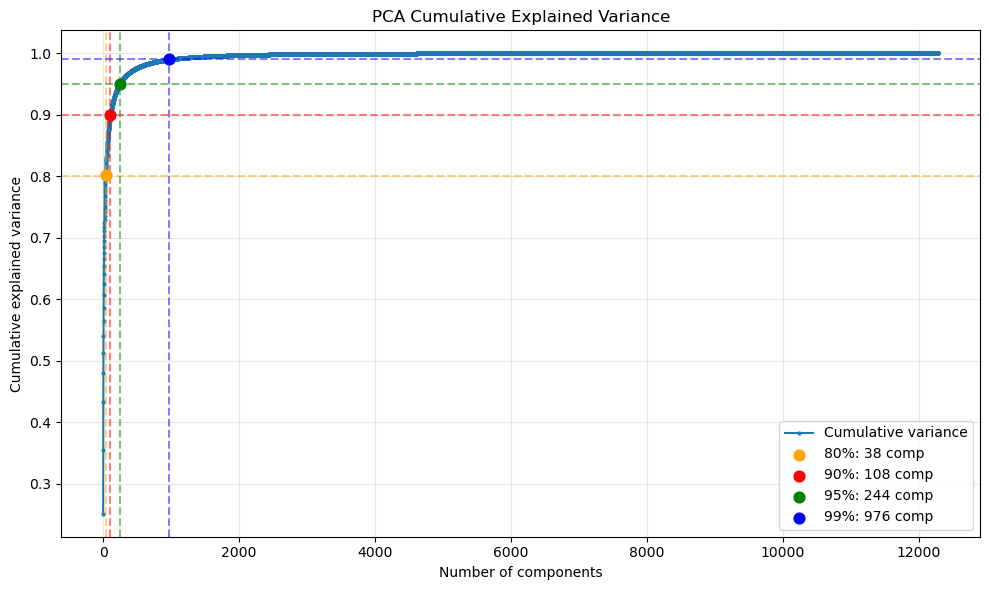

Components needed for each variance target:
  80% variance: 38 components
  90% variance: 108 components
  95% variance: 244 components
  99% variance: 976 components


In [27]:
pca_full = PCA(n_components=min(X_train_sc.shape), random_state=RANDOM_STATE)
pca_full.fit(X_train_sc)

explained = pca_full.explained_variance_ratio_
cumsum = np.cumsum(explained)

targets = [0.80, 0.90, 0.95, 0.99]
components_for_target = {}

for t in targets:
    k = np.argmax(cumsum >= t) + 1
    components_for_target[t] = k

plt.figure(figsize=(10, 6))
plt.plot(range(1, len(cumsum) + 1), cumsum, marker='o', markersize=2, label='Cumulative variance')

colors = ['orange', 'red', 'green', 'blue']
for (t, k), col in zip(components_for_target.items(), colors):
    plt.axhline(t, color=col, linestyle='--', alpha=0.5)
    plt.axvline(k, color=col, linestyle='--', alpha=0.5)
    plt.scatter(k, cumsum[k-1], color=col, s=60, zorder=5, 
                label=f'{int(t*100)}%: {k} comp')

plt.xlabel('Number of components')
plt.ylabel('Cumulative explained variance')
plt.title('PCA Cumulative Explained Variance')
plt.grid(alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

print("Components needed for each variance target:")
for t, k in components_for_target.items():
    print(f"  {int(t*100)}% variance: {k} components")


In [33]:
n_components_candidates = [
    components_for_target[0.90],
    components_for_target[0.95],
    components_for_target[0.99],
]

C_values = [10, 100]
gamma_values = [0.01, 0.001]

X_train_sub, _, y_train_sub, _ = train_test_split(
    X_train_sc, y_train,
    train_size=0.2,
    random_state=RANDOM_STATE,
    stratify=y_train,
)

print(f"Using subset of size {len(X_train_sub)} from {len(X_train_sc)} for tuning")

results = []

for n_comp in n_components_candidates:
    pca_temp = PCA(n_components=n_comp, random_state=RANDOM_STATE)
    X_sub_pca = pca_temp.fit_transform(X_train_sub)
    
    for C in C_values:
        for gamma in gamma_values:
            svm = SVC(C=C, gamma=gamma, kernel='rbf', random_state=RANDOM_STATE)
            scores = cross_val_score(
                svm, X_sub_pca, y_train_sub,
                cv=3, scoring='accuracy', n_jobs=-1,
            )
            mean_score = scores.mean()
            results.append({
                'n_components': n_comp,
                'C': C,
                'gamma': gamma,
                'cv_accuracy': mean_score,
            })
            print(f"n_comp={n_comp:4d}, C={C:3d}, gamma={gamma:.2f} -> CV acc {mean_score:.4f}")

results_df = pd.DataFrame(results).sort_values('cv_accuracy', ascending=False)
best_config = results_df.iloc[0]

print("\nTop configurations:")
print(results_df.head(10))

print("\nBEST CONFIGURATION")
print(f"n_components: {int(best_config['n_components'])}")
print(f"C: {best_config['C']}")
print(f"gamma: {best_config['gamma']}")
print(f"CV accuracy: {best_config['cv_accuracy']:.4f}")


Using subset of size 5171 from 25855 for tuning
n_comp= 108, C= 10, gamma=0.01 -> CV acc 0.4438
n_comp= 108, C= 10, gamma=0.00 -> CV acc 0.8265
n_comp= 108, C=100, gamma=0.01 -> CV acc 0.4438
n_comp= 108, C=100, gamma=0.00 -> CV acc 0.8265
n_comp= 244, C= 10, gamma=0.01 -> CV acc 0.3614
n_comp= 244, C= 10, gamma=0.00 -> CV acc 0.7859
n_comp= 244, C=100, gamma=0.01 -> CV acc 0.3614
n_comp= 244, C=100, gamma=0.00 -> CV acc 0.7859
n_comp= 976, C= 10, gamma=0.01 -> CV acc 0.2595
n_comp= 976, C= 10, gamma=0.00 -> CV acc 0.7235
n_comp= 976, C=100, gamma=0.01 -> CV acc 0.2595
n_comp= 976, C=100, gamma=0.00 -> CV acc 0.7235

Top configurations:
    n_components    C  gamma  cv_accuracy
1            108   10  0.001     0.826535
3            108  100  0.001     0.826535
5            244   10  0.001     0.785923
7            244  100  0.001     0.785923
9            976   10  0.001     0.723457
11           976  100  0.001     0.723457
0            108   10  0.010     0.443819
2            108  1

In [34]:
best_n_comp = int(best_config['n_components'])
best_C = best_config['C']
best_gamma = best_config['gamma']

pca_final = PCA(n_components=best_n_comp, random_state=RANDOM_STATE)

X_train_val_sc = np.concatenate([X_train_sc, X_val_sc], axis=0)
y_train_val = np.concatenate([y_train, y_val], axis=0)

X_train_val_pca = pca_final.fit_transform(X_train_val_sc)
X_test_pca = pca_final.transform(X_test_sc)

print("Train+Val PCA shape:", X_train_val_pca.shape)
print("Test PCA shape:", X_test_pca.shape)

svm_final = SVC(C=best_C, gamma=best_gamma, kernel='rbf', random_state=RANDOM_STATE)
svm_final.fit(X_train_val_pca, y_train_val)

y_test_pred = svm_final.predict(X_test_pca)
test_acc = accuracy_score(y_test, y_test_pred)

print(f"\nFinal test accuracy: {test_acc:.4f}")


Train+Val PCA shape: (36936, 108)
Test PCA shape: (43442, 108)

Final test accuracy: 0.8577


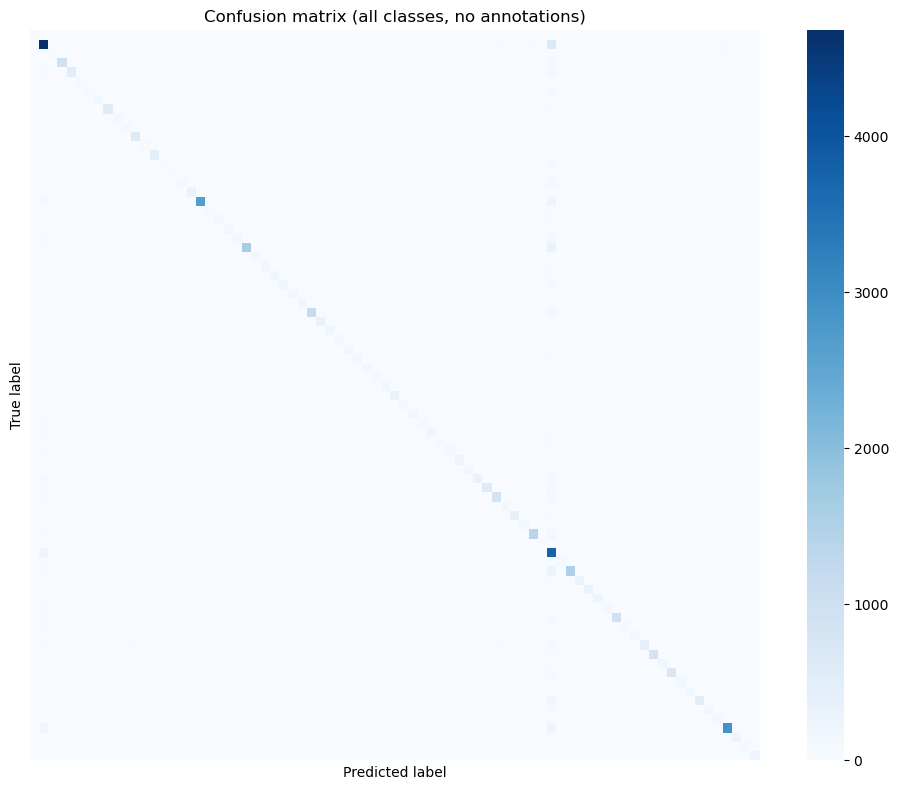

In [ ]:
import seaborn as sns

cm = confusion_matrix(y_test, y_test_pred)

plt.figure(figsize=(10, 8))
sns.heatmap(
    cm,
    cmap="Blues",
    cbar=True,
    square=True,
    xticklabels=False,
    yticklabels=False   
)
plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.title("Confusion matrix (all classes, no annotations)")
plt.tight_layout()
plt.show()


In [36]:
target_names = [subset_dataset_64.idx_to_label[i] for i in range(len(subset_dataset_64.label_to_idx))]

print("\nClassification Report (per class):")
print(classification_report(
    y_test, y_test_pred,
    target_names=target_names,
    zero_division=0
))


Classification Report (per class):
              precision    recall  f1-score   support

     Almonds       1.00      1.00      1.00        77
       Apple       0.79      0.85      0.82      5506
     Apricot       0.97      0.55      0.70       164
     Avocado       0.97      0.91      0.94      1017
      Banana       0.96      0.79      0.87       645
       Beans       1.00      1.00      1.00        77
    Beetroot       0.94      0.49      0.65       150
  BlackBerry       1.00      1.00      1.00       145
 Blackberrie       1.00      0.93      0.96       600
   Blueberry       1.00      0.75      0.86       154
     Cabbage       1.00      1.00      1.00        96
      Cactus       0.96      0.92      0.94       634
        Caju       1.00      0.97      0.99        75
  Cantaloupe       1.00      1.00      1.00       484
   Carambula       1.00      0.51      0.68       166
      Carrot       1.00      1.00      1.00        50
 Cauliflower       1.00      0.46      0.63  

Per 64×64 non è stato possibile usare tutti i dati per limiti computazionali; anche su un subset bilanciato PCA+SVM ha prestazioni molto inferiori rispetto agli altri setup, evidenziando i limiti dell’approccio in alta dimensione.